In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/documents/kaggle'

In [4]:
! kaggle datasets download -d batou9150/french-names

Dataset URL: https://www.kaggle.com/datasets/batou9150/french-names
License(s): CC0-1.0
100% 24.0M/24.1M [00:02<00:00, 11.5MB/s]
100% 24.1M/24.1M [00:02<00:00, 9.19MB/s]


In [5]:
! unzip -qq french-names.zip

In [6]:
data = pd.read_csv('noms2008dep.tsv', sep='\t', low_memory=False)

In [7]:
data.head(10)

,NOM,DEP,_1891_1900,_1901_1910,_1911_1920,_1921_1930,_1931_1940,_1941_1950,_1951_1960,_1961_1970,_1971_1980,_1981_1990,_1991_2000
0,ABRY,01,2,15,13,4,5,15,9,9,14,6,4
1,ACHARD,01,6,4,5,4,7,5,3,6,2,5,5
2,ADAM,01,14,26,17,15,20,13,12,16,14,16,5
3,ADENOT,01,0,0,0,0,5,7,7,6,1,4,1
4,ADOBATI,01,0,5,4,7,10,6,2,10,2,5,2
5,AGNIEL,01,5,4,4,7,5,3,1,4,1,0,6
6,AJOUX,01,8,4,9,5,4,5,8,6,3,11,0
7,ALAMERCERY,01,8,12,13,7,12,10,3,1,5,6,2
8,ALBAN,01,26,24,13,18,16,26,15,11,14,14,2
9,ALBERT,01,3,2,4,4,4,0,0,5,4,1,5


In [8]:
data.dtypes

,0
NOM,object
DEP,object
_1891_1900,int64
_1901_1910,int64
_1911_1920,int64
_1921_1930,int64
_1931_1940,int64
_1941_1950,int64
_1951_1960,int64
_1961_1970,int64


In [9]:
X = data.NOM

In [10]:
X

,NOM
0,ABRY
1,ACHARD
2,ADAM
3,ADENOT
4,ADOBATI
...,...
521512,ZYGMUNT
521513,ZYLBERBERG
521514,ZYLBERMAN
521515,ZYSMAN


In [11]:
X.isna().sum()

0

In [12]:
X.shape

(521517,)

In [13]:
X_arr = X.to_list()

In [14]:
X_arr[:5]

['ABRY', 'ACHARD', 'ADAM', 'ADENOT', 'ADOBATI']

In [15]:
type(X_arr[0])

str

In [16]:
X_arr = list(map(lambda x: x.lower(), X_arr))
X_arr[:5]

['abry', 'achard', 'adam', 'adenot', 'adobati']

In [17]:
X_np = np.array(X)
X_np.shape

(521517,)

In [18]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [19]:
plt.rcParams.update({'font.size': 15})
sns.set(style='darkgrid')

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_np, X_np, test_size=0.25, random_state=42)

In [22]:
X_train.shape, X_valid.shape

((391137,), (130380,))

In [23]:
class NomsDataset(Dataset):
    def __init__(self, names):
        super().__init__()

        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        self.vocab = build_vocab_from_iterator(self.names, specials=self.specials)
        self.itos = self.vocab.get_itos()
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']

        self.max_len = max([len(name) for name in self.names]) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]

    def idx_to_str(self, idx):
        return [self.itos[index] for index in idx]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)

        return padded, len(padded)

In [24]:
train_dataset = NomsDataset(X_train)
valid_dataset = NomsDataset(X_valid)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [26]:
for names, lengths in train_loader:
    break

In [27]:
names[:4]

tensor([[ 1, 11, 18,  7,  3,  5, 21,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 22,  3,  5, 10, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 12, 11,  5,  4, 11, 16,  4,  7,  9, 12,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19,  5,  3, 11,  3, 12,  3,  7,  8,  8,  3,  2,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

Generator model

In [28]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.distributions.categorical import Categorical

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [30]:
class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()

        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim, padding_idx=dataset.pad_index)
        self.rnn = nn.RNN(input_size=self.embed_dim, hidden_size=self.hidden_dim, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, len(dataset.vocab))


    def forward(self, tokens, lengths):
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # padded embeds: (B, L, E)
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        # packed_embeds: (B * L, E) - I think that it's packed form for (B, L, E)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1]
        # print("1 tokens: ", tokens)
        # print("1 tokens len: ", len(tokens))
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)
        # print("1 tokens shape: ", tokens.shape)

        # generate hidden for prefix
        embeds = self.embedding(tokens)
        # print("1 embeds: ", embeds)
        # print("1 embeds shape: ", embeds.shape)
        output, hidden = self.rnn(embeds)
        # print("1 output: ", output)
        # print("1 output shape: ", output.shape)
        logits = self.linear(output)
        # print("1 logits: ", logits)
        # print("1 logits shape: ", logits.shape)

        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds)
            logits = self.linear(output)
            # sample next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # decode result to a string
        return self.dataset.decode(tokens.squeeze())



# Explore Generator pipeline

In [31]:
rand_embeds = torch.rand(32, 34)

In [32]:
rand_embeds.shape

torch.Size([32, 34])

In [33]:
names.shape

torch.Size([32, 34])

In [34]:
embeds = torch.stack((names, rand_embeds))

In [35]:
embeds.shape

torch.Size([2, 32, 34])

In [36]:
embeds = embeds.view(32, 34, 2)

In [37]:
embeds.shape

torch.Size([32, 34, 2])

In [38]:
lengths.shape

torch.Size([32])

In [39]:
packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)

In [40]:
for x in packed_embeds:
    print(x.shape)
    break

torch.Size([1088, 2])


In [41]:
packed_embeds.data.shape

torch.Size([1088, 2])

In [42]:
rnn = nn.RNN(input_size=2, hidden_size=4, batch_first=True)

In [43]:
x = x.view(32, 34, 2)

In [44]:
outputs, hidden = rnn(packed_embeds)

In [45]:
outputs.data.shape

torch.Size([1088, 4])

In [46]:
hidden.shape

torch.Size([1, 32, 4])

In [47]:
hidden

tensor([[[-0.1904,  0.1550, -0.0717, -0.7551],
         [-0.1902,  0.1550, -0.0715, -0.7548],
         [-0.1904,  0.1549, -0.0717, -0.7551],
         [-0.1903,  0.1550, -0.0717, -0.7549],
         [-0.1971,  0.1569, -0.0772, -0.7657],
         [-0.1903,  0.1550, -0.0717, -0.7549],
         [-0.1904,  0.1549, -0.0717, -0.7551],
         [-0.1903,  0.1550, -0.0717, -0.7549],
         [-0.1903,  0.1550, -0.0717, -0.7549],
         [-0.1904,  0.1549, -0.0717, -0.7551],
         [-0.1904,  0.1549, -0.0717, -0.7551],
         [-0.1903,  0.1549, -0.0717, -0.7550],
         [-0.1903,  0.1549, -0.0716, -0.7551],
         [-0.1903,  0.1549, -0.0716, -0.7551],
         [-0.1903,  0.1549, -0.0716, -0.7551],
         [-0.1904,  0.1550, -0.0717, -0.7551],
         [ 0.1453,  0.3534, -0.2577, -0.7635],
         [ 0.1791,  0.4266, -0.2796, -0.6875],
         [ 0.1753,  0.3312, -0.2370, -0.7666],
         [ 0.0710,  0.2194, -0.2428, -0.6673],
         [ 0.1228,  0.3158, -0.2063, -0.6990],
         [-0.

In [48]:
outputs_new, lengths_new = pad_packed_sequence(outputs, batch_first=True)

In [49]:
outputs_new.shape

torch.Size([32, 34, 4])

In [50]:
lengths_new.shape

torch.Size([32])

# ---



In [51]:
model = Generator(train_dataset, embed_dim=32, hidden_dim=32).to(device)

In [52]:
train_dataset.encode('')

[1, 2]

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [54]:
loss_fn = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_index)

In [55]:
model.inference()

"UTVQYQQKOVFNIYTFJHIGWMYU'X'EZKH"

In [56]:
len(train_dataset.vocab)

32

# Exploring inference pipeline

In [57]:
logits = torch.Tensor([[[ 0.4179, -0.3476,  0.3847,  0.0851, -0.2328, -0.3679, -0.5470,
          -0.1923, -0.1766,  0.3295, -0.3175,  0.0686,  0.2674,  0.3709,
           0.1009, -0.1573,  0.0119, -0.1613, -0.2364, -0.2335,  0.4995,
           0.0303,  0.0308,  0.3081,  0.4350, -0.0662, -0.1344, -0.0069,
          -0.1249,  0.2630, -0.3675, -0.1635]]])

In [58]:
logits.shape

torch.Size([1, 1, 32])

In [59]:
logits[:, -1:]

tensor([[[ 0.4179, -0.3476,  0.3847,  0.0851, -0.2328, -0.3679, -0.5470,
          -0.1923, -0.1766,  0.3295, -0.3175,  0.0686,  0.2674,  0.3709,
           0.1009, -0.1573,  0.0119, -0.1613, -0.2364, -0.2335,  0.4995,
           0.0303,  0.0308,  0.3081,  0.4350, -0.0662, -0.1344, -0.0069,
          -0.1249,  0.2630, -0.3675, -0.1635]]])

In [60]:
logits[:, -1:].shape

torch.Size([1, 1, 32])

In [61]:
new_tokens = Categorical(logits=logits[:, -1:]).sample()

In [62]:
new_tokens

tensor([[31]])

In [63]:
tokens = torch.Tensor([[1]])
tokens

tensor([[1.]])

In [64]:
next_tokens = torch.cat([tokens, new_tokens], dim=1)

In [65]:
next_tokens

tensor([[ 1., 31.]])

In [66]:
train_dataset.eos_index

2

# ---

# Training

In [67]:
def plot_losses(losses):
    clear_output()
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [68]:
losses = []
num_epochs = 200

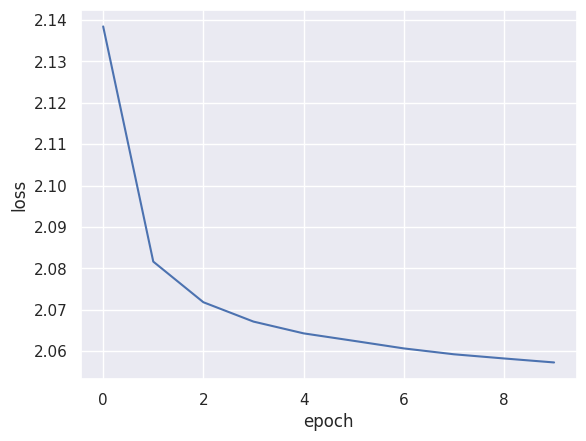

KeyboardInterrupt: 

In [69]:
for epoch in tqdm(range(1, num_epochs + 1)):
    running_loss = 0
    model.train()
    for tokens, lengths in train_loader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) -- need to transpose logits
        loss = loss_fn(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        running_loss += loss.item() * tokens.shape[0]
        optimizer.step()

    losses += [running_loss / len(train_loader.dataset)]

    if epoch % 10 == 0:
        plot_losses(losses)

In [73]:
[model.inference() for _ in range(10)]

['DILEANONEWTEGENOUGAIS',
 'FLELEATINE',
 'LVESATAIS',
 'BISTOPENENERANETENIENEROFOUGEFREN',
 'JANEMANISTETOSESAGEROUFLERENEROTO',
 'LONELI',
 'FYEENORESENENEMAGENE',
 'ERENOTANANEDINEELERE',
 'DANIEZ',
 'BAROTE']